Acquire and Summarize

Acquire data from the cloud database.

You will want to end with a single dataframe. Include the logerror field and all other fields related to the properties that are available. You will end up using all the tables in the database.

Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid. - Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction. (Hint: read the docs for the .duplicated method) - Only include properties that have a latitude and longitude value.

Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.


-----------------num_rows_missing - pct_rows_missing

parcelid -------------------------	0 -	0.000000

airconditioningtypeid -----	29041 -	0.535486

architecturalstyletypeid --	54232 -	0.999982

Prepare

Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer.

Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

The input:
A dataframe
A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).
The output:
The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.
hint:
Look up the dropna documentation.
You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.
Encapsulate your work inside of functions in a wrangle_zillow.py module.

In [82]:
import numpy as np
import pandas as pd
import env
import os
import matplotlib.pyplot as plt

In [7]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [43]:
def new_zillow_db():
    '''The function uses the get_connection function to connect to a database and retrieve the zillow dataset'''
    
    zillow = pd.read_sql('''
    SELECT p.id, p.parcelid, pd.logerror, pd.transactiondate, p.airconditioningtypeid, ac.airconditioningdesc, 
    p.architecturalstyletypeid, a.architecturalstyledesc, p.basementsqft, p.bathroomcnt, p.bedroomcnt, 
    p.buildingclasstypeid, b.buildingclassdesc, p.buildingqualitytypeid, p.calculatedbathnbr, p.decktypeid, 
    p.finishedfloor1squarefeet, p.calculatedfinishedsquarefeet, p.finishedsquarefeet12, p.finishedsquarefeet13, 
    p.finishedsquarefeet15, p.finishedsquarefeet50, p.finishedsquarefeet6, p.fips, p.fireplacecnt, p.fullbathcnt, 
    p.garagecarcnt, p.garagetotalsqft, p.hashottuborspa, p.heatingorsystemtypeid, h.heatingorsystemdesc, p.latitude, 
    p.longitude, p.lotsizesquarefeet, p.poolcnt, p.poolsizesum, p.pooltypeid10, p.pooltypeid2, p.pooltypeid7, 
    p.propertycountylandusecode, p.propertylandusetypeid, l.propertylandusedesc, p.propertyzoningdesc, p.rawcensustractandblock, 
    p.regionidcity, p.regionidneighborhood, p.regionidzip, p.roomcnt, p.storytypeid, p.threequarterbathnbr, 
    p.typeconstructiontypeid, p.unitcnt, p.yardbuildingsqft17, p.yardbuildingsqft26, p.yearbuilt, p.numberofstories, 
    p.fireplaceflag, p.structuretaxvaluedollarcnt, p.taxvaluedollarcnt, p.assessmentyear, p.landtaxvaluedollarcnt, 
    p.taxamount, p.taxdelinquencyflag, p.taxdelinquencyyear, p.censustractandblock

    FROM properties_2017 as p
    RIGHT JOIN predictions_2017 as pd
    ON p.id = pd.id
    LEFT JOIN airconditioningtype as ac
    ON p.airconditioningtypeid = ac.airconditioningtypeid
    LEFT JOIN architecturalstyletype as a
    ON p.architecturalstyletypeid = a.architecturalstyletypeid
    LEFT JOIN buildingclasstype as b
    ON p.buildingclasstypeid = b.buildingclasstypeid
    LEFT JOIN heatingorsystemtype as h
    ON p.heatingorsystemtypeid = h.heatingorsystemtypeid
    LEFT JOIN propertylandusetype as l
    ON p.propertylandusetypeid = l.propertylandusetypeid
    LEFT JOIN storytype as s
    ON p.storytypeid = s.storytypeid
    LEFT JOIN typeconstructiontype as t
    ON p.typeconstructiontypeid = t.typeconstructiontypeid
    LEFT JOIN unique_properties as u
    ON p.parcelid = u.parcelid
    WHERE propertylandusedesc IN ("Single Family Residential")
    AND pd.transactiondate BETWEEN '2017-01-01' AND '2017-12-31'
    AND p.latitude IS NOT NULL
    AND p.longitude IS NOT NULL

    ;''', get_connection('zillow'))
    return zillow

In [44]:
def get_zillow_data():
    ''' This function reads in telco data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.'''
    if os.path.isfile('zillow.csv'):
        # If csv file exists read in data from csv file.
        df = pd.read_csv('zillow.csv', index_col=0)     
    else:   
        # Read fresh data from db into a DataFrame
        df = new_zillow_db()
        # Cache data
        df.to_csv('zillow.csv')

In [45]:
df = new_zillow_db()

In [46]:
num_missing = df.isnull().sum(axis=1)
prnt_miss = num_missing / df.shape[1] * 100

In [47]:
rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prnt_miss})

In [49]:
def nulls_by_row(df):
    num_missing = df.isnull().sum(axis=1)
    prnt_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prnt_miss}).\
    reset_index().groupby(['num_cols_missing', 'percent_cols_missing']).count().\
    reset_index().rename(columns={'customer_id': 'count'})
    return rows_missing

In [50]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    prnt_miss = num_missing / df.shape[0] * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prnt_miss}).\
    reset_index().groupby(['num_rows_missing', 'percent_rows_missing']).count().reset_index().\
    rename(columns={'index': 'count'})
    return cols_missing

In [51]:
def summarize(df):
    print('DataFrame head: \n')
    print(df.head())
    print('----------')
    print('DataFrame info: \n')
    print(df.info())
    print('----------')
    print('DataFrame description: \n')
    print(df.describe())
    print('----------')
    print('Null value assessments: \n')
    print('Nulls by column: ', nulls_by_col(df))
    print('----------')
    print('Nulls by row: ', nulls_by_row(df))
    numerical_cols = [col for col in df.columns if df[col].dtypes != 'O']
    cat_cols = [col for col in df.columns if col not in numerical_cols]
    print('----------')
    print('Value counts: \n')
    for col in df.columns:
        if col in cat_cols:
            print(df[col].value_counts())
        else:
            print(df[col].value_counts(bins=10, sort=False))
        print('-----')
    print('----------')
    print('Report Finished')

In [52]:
summarize(df)

DataFrame head: 

   id  parcelid  logerror transactiondate  airconditioningtypeid  \
0   1  10759547  0.055619      2017-01-01                    NaN   
1  15  11193347  0.008669      2017-01-02                    NaN   
2  16  11215747 -0.021896      2017-01-02                    NaN   
3  17  11229347 -0.017167      2017-01-02                    NaN   
4  20  11324547  0.042463      2017-01-02                    1.0   

  airconditioningdesc  architecturalstyletypeid architecturalstyledesc  \
0                None                       NaN                   None   
1                None                       NaN                   None   
2                None                       NaN                   None   
3                None                       NaN                   None   
4             Central                       NaN                   None   

   basementsqft  bathroomcnt  ...  numberofstories fireplaceflag  \
0           NaN          0.0  ...              NaN          

Nulls by row:      num_cols_missing  percent_cols_missing  index
0                 23             35.384615     10
1                 24             36.923077     17
2                 25             38.461538    106
3                 26             40.000000    324
4                 27             41.538462   2543
5                 28             43.076923   2078
6                 29             44.615385   6319
7                 30             46.153846   8789
8                 31             47.692308  12961
9                 32             49.230769  13333
10                33             50.769231   3796
11                34             52.307692   4187
12                35             53.846154    996
13                36             55.384615    259
14                37             56.923077     82
15                38             58.461538     45
16                39             60.000000     12
17                40             61.538462     13
18                41             63

In [53]:
df.duplicated(subset='parcelid').sum()

0

In [54]:
df.propertylandusedesc.value_counts()

Single Family Residential    56079
Name: propertylandusedesc, dtype: int64

In [62]:
def get_upper_outliers(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_bound = q3 + k*iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

In [64]:
get_upper_outliers(df.taxvaluedollarcnt)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
56074    0.0
56075    0.0
56076    0.0
56077    0.0
56078    0.0
Name: taxvaluedollarcnt, Length: 56079, dtype: float64

In [65]:
def add_upper_outlier_columns(df, k=1.5):
    for col in df.select_dtypes('number'):
        df[col + '_upper_outliers'] = get_upper_outliers(df[col], k)
    return df

In [66]:
df = add_upper_outlier_columns(df)

In [67]:
outlier_cols = [col for col in df.columns if col.endswith('outliers')]

In [68]:
cols_to_remove = ['buildingclasstypeid', 'buildingclassdesc', 'finishedsquarefeet13', 'finishedsquarefeet15']

In [69]:
def remove_columns(df, cols_to_remove):  
    df = df.drop(columns=cols_to_remove)
    return df

In [70]:
def handle_missing_values(df, 
                          prop_required_columns=0.5, 
                          prop_required_row=0.75):
    threshold = int(round(prop_required_columns * len(df.index), 0))
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=threshold)
    return df

In [71]:
df = handle_missing_values(df)

In [72]:
df

,id,parcelid,logerror,transactiondate,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,...,regionidzip_upper_outliers,roomcnt_upper_outliers,unitcnt_upper_outliers,yearbuilt_upper_outliers,structuretaxvaluedollarcnt_upper_outliers,taxvaluedollarcnt_upper_outliers,assessmentyear_upper_outliers,landtaxvaluedollarcnt_upper_outliers,taxamount_upper_outliers,censustractandblock_upper_outliers
4,20,11324547,0.042463,2017-01-02,2.0,4.0,8.0,2.0,3633.0,3633.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6,31,11544747,-0.019546,2017-01-02,4.0,3.0,11.0,4.0,1620.0,1620.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
7,33,11585547,-0.040807,2017-01-02,2.0,3.0,8.0,2.0,2077.0,2077.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
11,62,11954547,0.069858,2017-01-02,0.0,0.0,NaN,NaN,1200.0,1200.0,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN
14,97,12537947,0.020950,2017-01-02,0.0,0.0,NaN,NaN,171.0,171.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56074,77607,11212164,0.001082,2017-09-19,2.0,2.0,8.0,2.0,1362.0,1362.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56075,77608,11212264,-0.002245,2017-09-20,2.0,3.0,8.0,2.0,1600.0,1600.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56076,77609,11212539,0.020615,2017-09-20,3.0,4.0,8.0,3.0,1921.0,1921.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56077,77610,11212639,0.013209,2017-09-21,3.0,4.0,8.0,3.0,1780.0,1780.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
pd.DataFrame(summarize(df))

DataFrame head: 

    id  parcelid  logerror transactiondate  bathroomcnt  bedroomcnt  \
4   20  11324547  0.042463      2017-01-02          2.0         4.0   
6   31  11544747 -0.019546      2017-01-02          4.0         3.0   
7   33  11585547 -0.040807      2017-01-02          2.0         3.0   
11  62  11954547  0.069858      2017-01-02          0.0         0.0   
14  97  12537947  0.020950      2017-01-02          0.0         0.0   

    buildingqualitytypeid  calculatedbathnbr  calculatedfinishedsquarefeet  \
4                     8.0                2.0                        3633.0   
6                    11.0                4.0                        1620.0   
7                     8.0                2.0                        2077.0   
11                    NaN                NaN                        1200.0   
14                    NaN                NaN                         171.0   

    finishedsquarefeet12  ...  regionidzip_upper_outliers  \
4                 3633.0 

(-4.666, -3.664]        2
(-3.664, -2.672]        0
(-2.672, -1.68]        28
(-1.68, -0.688]       106
(-0.688, 0.304]     54371
(0.304, 1.296]       1203
(1.296, 2.287]         82
(2.287, 3.279]         55
(3.279, 4.271]          1
(4.271, 5.263]          1
Name: logerror, dtype: int64
-----
2017-06-30    887
2017-05-31    847
2017-05-26    711
2017-07-28    669
2017-04-28    667
             ... 
2017-05-20      1
2017-05-06      1
2017-02-18      1
2017-08-12      1
2017-04-15      1
Name: transactiondate, Length: 249, dtype: int64
-----
(-0.021, 2.0]    36097
(2.0, 4.0]       17756
(4.0, 6.0]        1753
(6.0, 8.0]         194
(8.0, 10.0]         43
(10.0, 12.0]         3
(12.0, 14.0]         1
(14.0, 16.0]         0
(16.0, 18.0]         0
(18.0, 20.0]         2
Name: bathroomcnt, dtype: int64
-----
(-0.026000000000000002, 2.5]     9465
(2.5, 5.0]                      45568
(5.0, 7.5]                        772
(7.5, 10.0]                        42
(10.0, 12.5]                    

""


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55849 entries, 4 to 56078
Data columns (total 61 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   id                                           55849 non-null  int64  
 1   parcelid                                     55849 non-null  int64  
 2   logerror                                     55849 non-null  float64
 3   transactiondate                              55849 non-null  object 
 4   bathroomcnt                                  55849 non-null  float64
 5   bedroomcnt                                   55849 non-null  float64
 6   buildingqualitytypeid                        36988 non-null  float64
 7   calculatedbathnbr                            55690 non-null  float64
 8   calculatedfinishedsquarefeet                 55839 non-null  float64
 9   finishedsquarefeet12                         55655 non-null  float64
 10

In [78]:
df = df.dropna()

In [79]:
df

,id,parcelid,logerror,transactiondate,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,...,regionidzip_upper_outliers,roomcnt_upper_outliers,unitcnt_upper_outliers,yearbuilt_upper_outliers,structuretaxvaluedollarcnt_upper_outliers,taxvaluedollarcnt_upper_outliers,assessmentyear_upper_outliers,landtaxvaluedollarcnt_upper_outliers,taxamount_upper_outliers,censustractandblock_upper_outliers
770,1287,10717217,0.012474,2017-01-06,2.0,3.0,8.0,2.0,1766.0,1766.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
771,1288,10718048,0.053889,2017-01-06,3.0,5.0,9.0,3.0,3085.0,3085.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
772,1289,10718101,-0.420413,2017-01-06,3.0,5.0,8.0,3.0,2401.0,2401.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
773,1290,10718224,0.005598,2017-01-06,3.0,4.0,7.0,3.0,2397.0,2397.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
774,1291,10718347,-0.094197,2017-01-06,3.0,4.0,7.0,3.0,2574.0,2574.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56074,77607,11212164,0.001082,2017-09-19,2.0,2.0,8.0,2.0,1362.0,1362.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56075,77608,11212264,-0.002245,2017-09-20,2.0,3.0,8.0,2.0,1600.0,1600.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56076,77609,11212539,0.020615,2017-09-20,3.0,4.0,8.0,3.0,1921.0,1921.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56077,77610,11212639,0.013209,2017-09-21,3.0,4.0,8.0,3.0,1780.0,1780.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Figure size 1152x648 with 0 Axes>

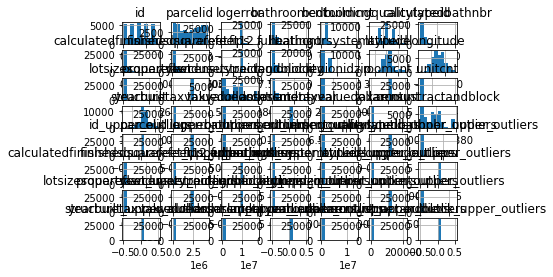

In [84]:
# df.rename(columns={'parcelid':'parcel', 'transactiondate':'transaction', 'bathroomcnt':'bathrooms', 'bedroomcnt':'bedrooms',
#                   'buildingqualitytypeid':'qualtypeid', 'calculatedbathnbr': 'baths_beds', 'calculatedfinishedsquarefeet':'sqft)', 
#                   ''})

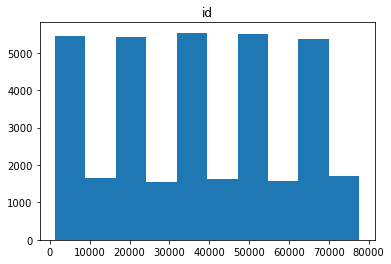

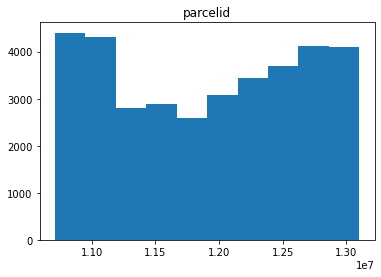

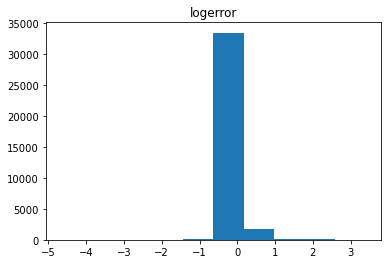

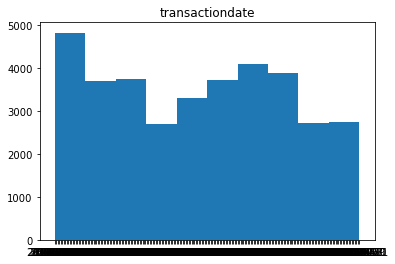

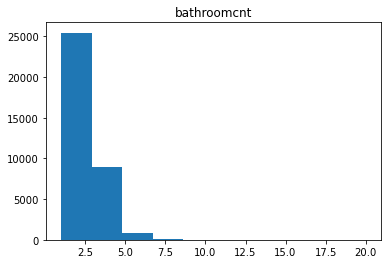

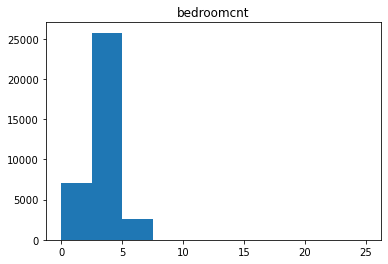

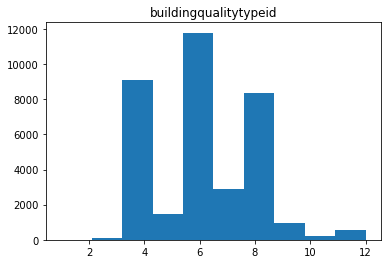

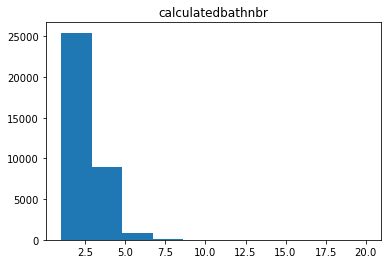

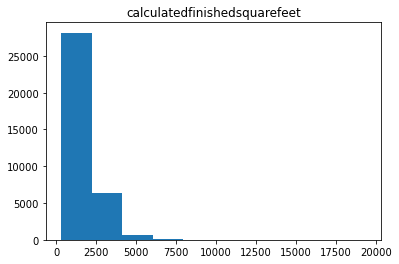

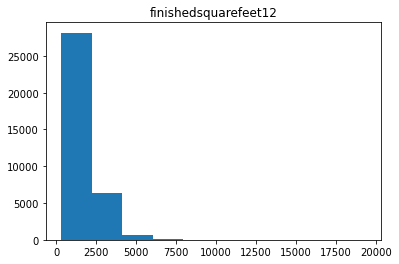

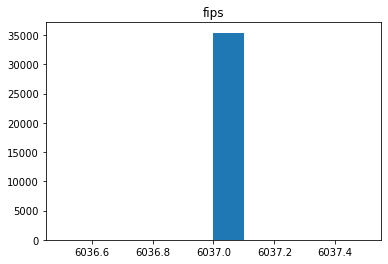

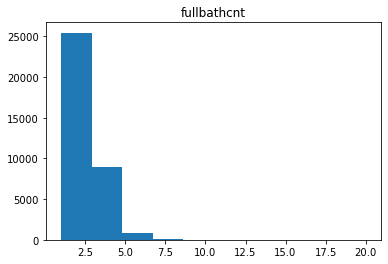

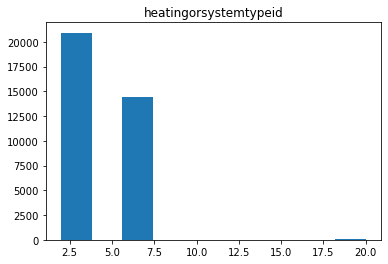

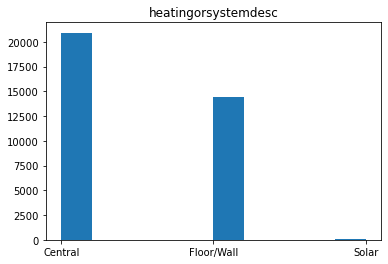

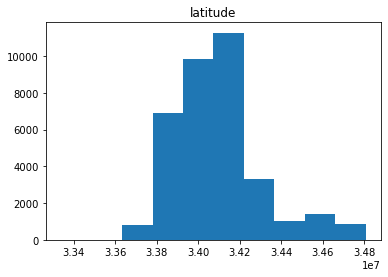

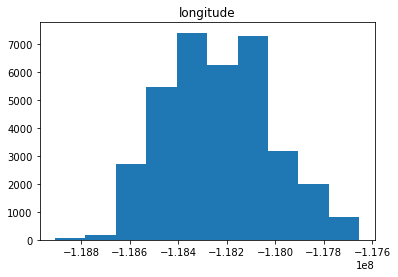

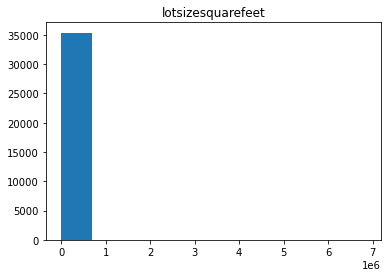

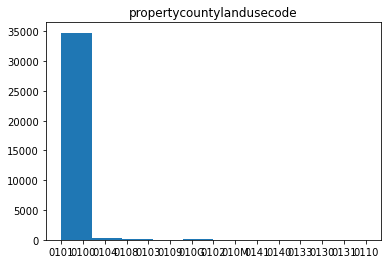

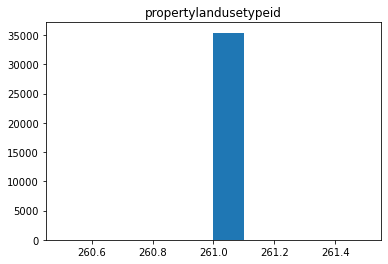

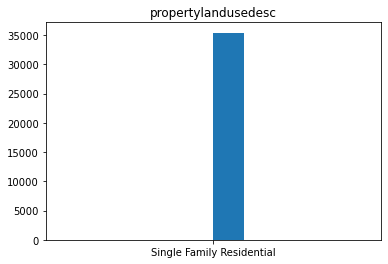

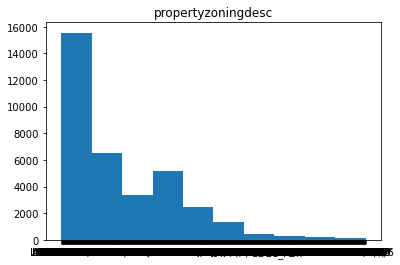

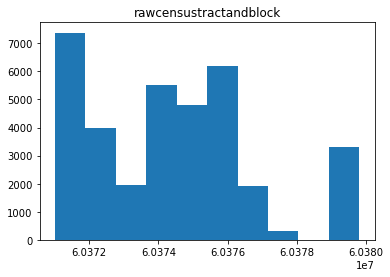

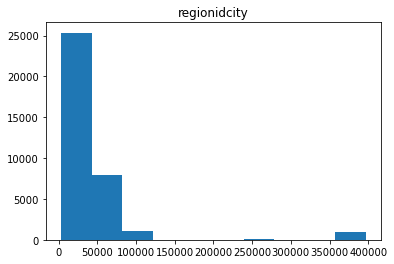

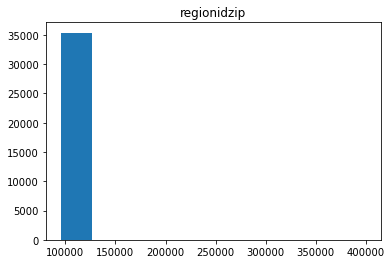

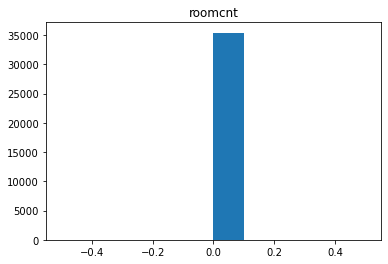

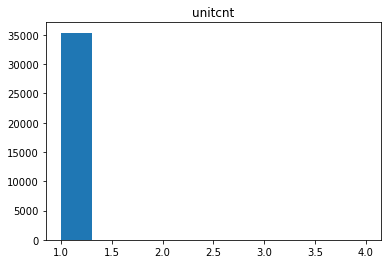

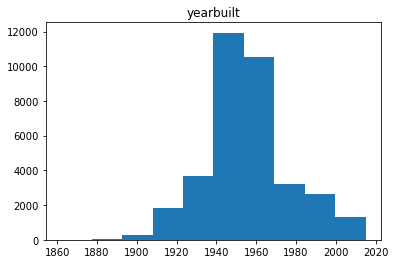

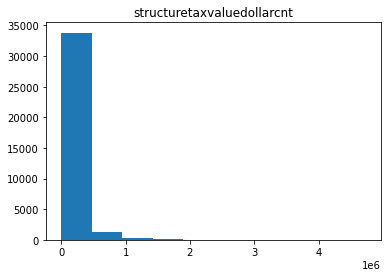

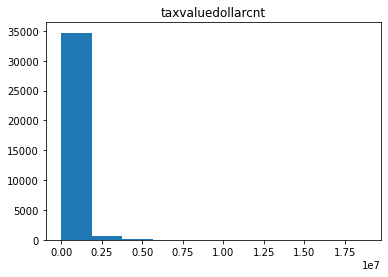

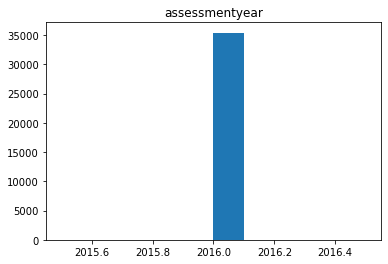

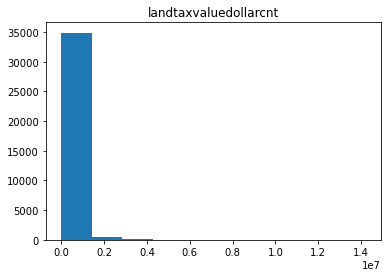

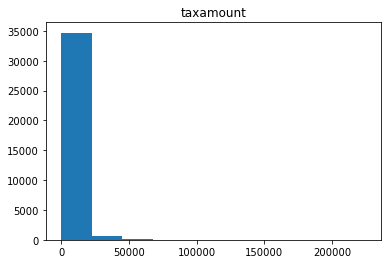

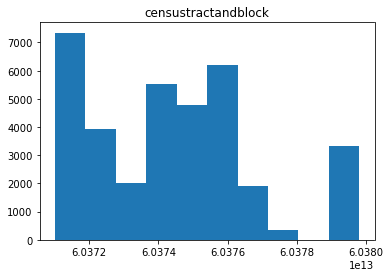

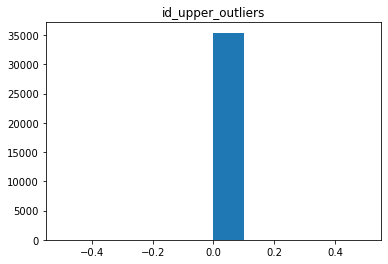

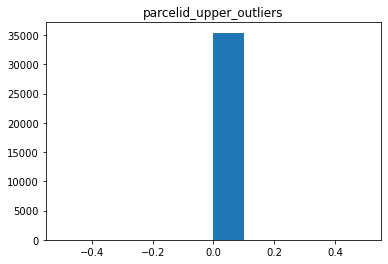

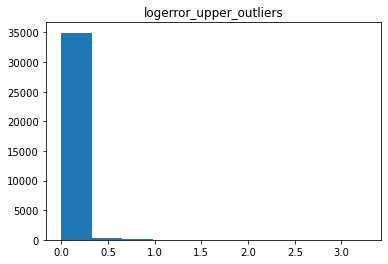

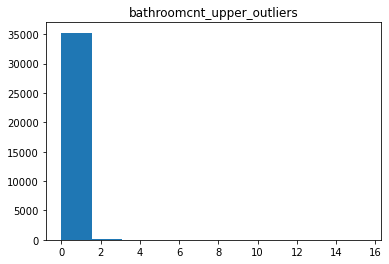

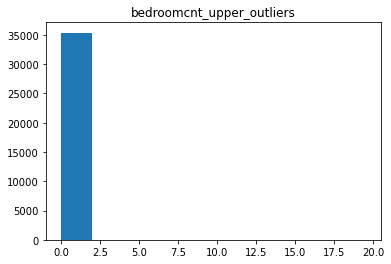

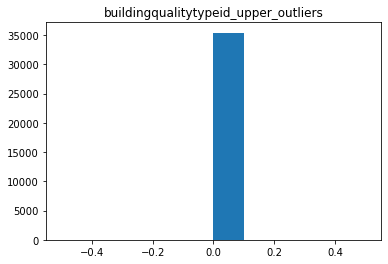

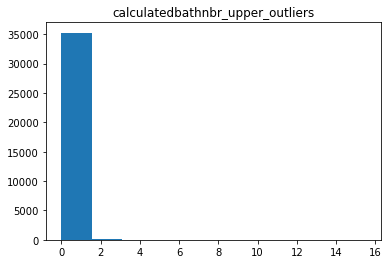

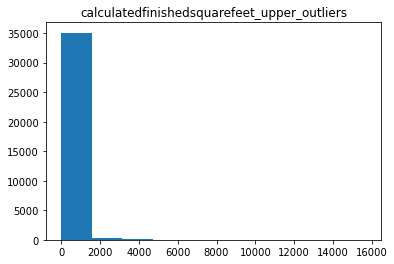

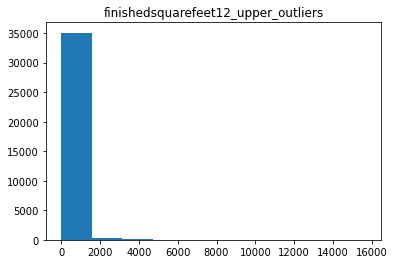

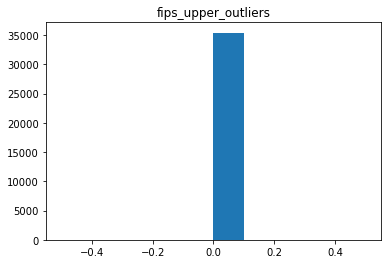

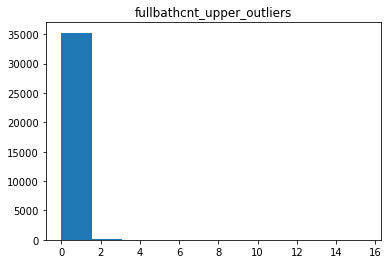

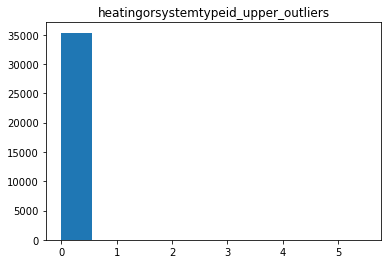

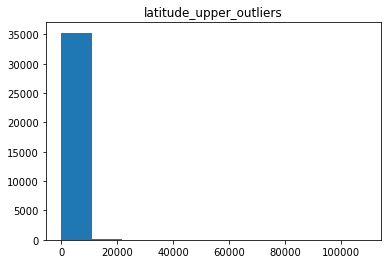

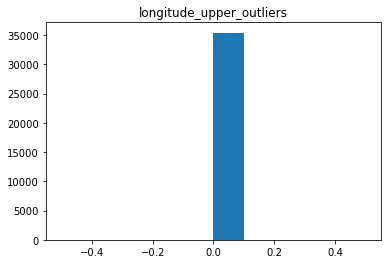

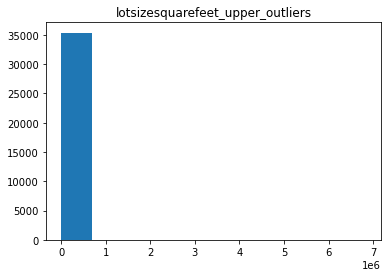

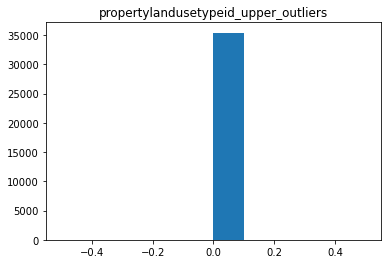

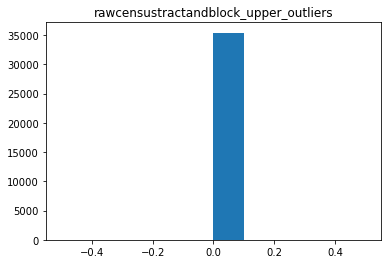

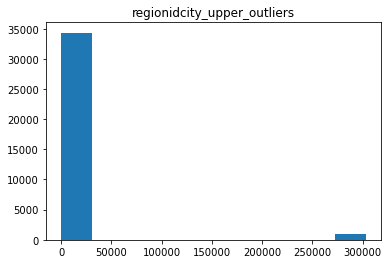

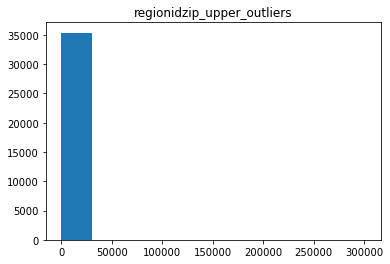

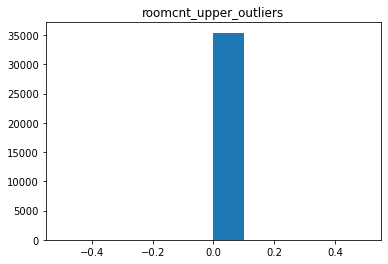

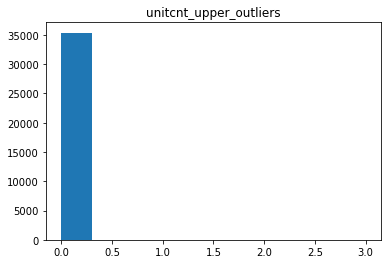

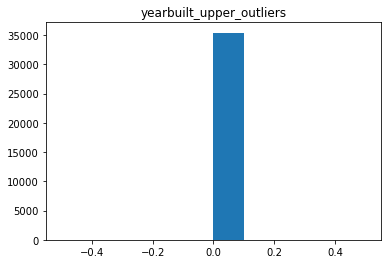

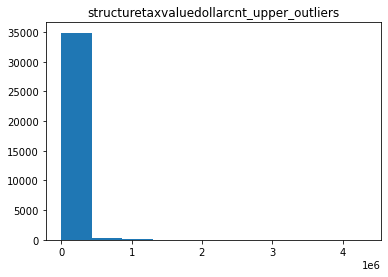

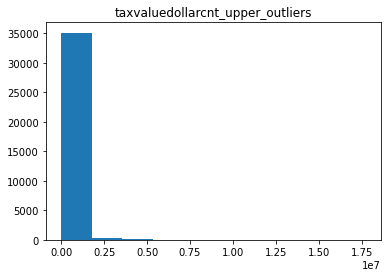

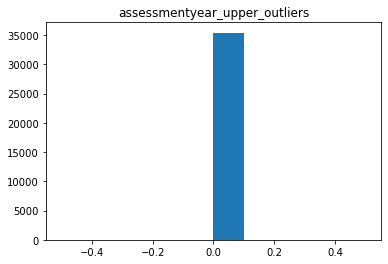

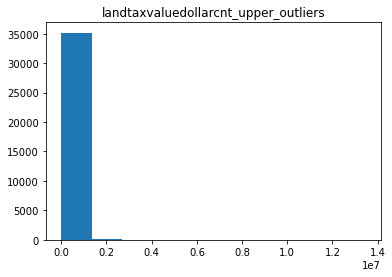

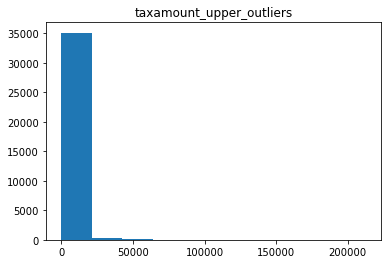

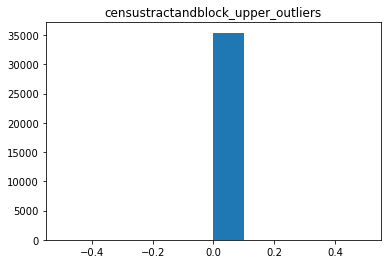

In [87]:
for col in df:
    plt.hist(df[col])
    plt.title(col)
    plt.show()